### Intro
#### Dataset:
- It's a tsv file
- Contains logs from a DNS server
- No other information

#### Task:
- Perform data analysis
- Explain found insights 
- For plotting use seaborn

## Data load and Validation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_palette('flare')

In [2]:
data = pd.read_csv('data.tsv', sep='\t', header=None)
data.columns = ['timestamp', 'top_level_domain', 'second_level_domain', 'FQDN', 'resolved IP address']

In [3]:
# Check if the data is corretly loaded
data.head(5)

,timestamp,top_level_domain,second_level_domain,FQDN,resolved IP address
0,1615334400,com,lightningphysics.com,www.lightningphysics.com,34.102.136.180
1,1615334400,com,petrhaupt.com,_sip._tcp.petrhaupt.com,81.2.195.16
2,1615334400,dk,cservice.dk,cservice.dk,185.21.41.135
3,1615334400,jp,petmode.jp,_sip._tcp.petmode.jp,150.95.255.38
4,1615334400,la,kh6p.int.la,kh6p.int.la,157.119.181.110


* Timestamp looks like it's a Unix time - i.e. seconds after 1970-01-01
* Second level domains contain top-level domains

Let's check if all rows are loaded and if there are any missing or empty values.

In [4]:
len(data)

1475866

In [5]:
data.isna().sum()

timestamp              0
top_level_domain       0
second_level_domain    0
FQDN                   0
resolved IP address    0
dtype: int64

In [6]:
data.apply(lambda x: x=='').sum()

timestamp              0
top_level_domain       0
second_level_domain    0
FQDN                   0
resolved IP address    0
dtype: int64

Extra features for time will be handy.

In [7]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data['time'] = data['datetime'].dt.time
data['weekday'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour

In [8]:
data.head(5)

,timestamp,top_level_domain,second_level_domain,FQDN,resolved IP address,datetime,date,time,weekday,hour
0,1615334400,com,lightningphysics.com,www.lightningphysics.com,34.102.136.180,2021-03-10,2021-03-10,00:00:00,2,0
1,1615334400,com,petrhaupt.com,_sip._tcp.petrhaupt.com,81.2.195.16,2021-03-10,2021-03-10,00:00:00,2,0
2,1615334400,dk,cservice.dk,cservice.dk,185.21.41.135,2021-03-10,2021-03-10,00:00:00,2,0
3,1615334400,jp,petmode.jp,_sip._tcp.petmode.jp,150.95.255.38,2021-03-10,2021-03-10,00:00:00,2,0
4,1615334400,la,kh6p.int.la,kh6p.int.la,157.119.181.110,2021-03-10,2021-03-10,00:00:00,2,0


Let's see the time range.

In [9]:
print(f"Dates range from {data['date'].min()} to {data['date'].max()}")

Dates range from 2021-03-10 to 2021-03-10


The only day is Wednesday - probably a working day.

In [10]:
print(f"Time ranges from {data['time'].min()} to {data['time'].max()}")

Time ranges from 00:00:00 to 23:51:42


Since the data is from a single day, then we can remove unnecesary columns.

In [11]:
data['minute'] = data['datetime'].dt.minute
data['hour_minute'] = data['datetime'].dt.time.apply(lambda x: str(x)[:-3])
data = data.drop(['datetime', 'date', 'weekday'], axis=1)

FQDN often has subdomain - which is easy to extract.

In [12]:
data['first_label'] = data['FQDN'].apply(lambda x: x.split('.')[0] if x.count('.')>1 else 'No first label')

## Analysis

### Let's see the most popular TLDs (top level domains)

In [13]:
top_level_rank = data.groupby('top_level_domain').count().iloc[:,0]
top_level_rank = top_level_rank.sort_values(ascending=False)
top_level_rank = top_level_rank.reset_index()
top_level_rank.columns = ['tld', 'visits']
top_level_rank['visits'] = top_level_rank['visits'].apply(lambda x: int(x*0.001))
top_level_rank.head(10)

,tld,visits
0,com,434
1,ws,126
2,ph,120
3,cn,93
4,de,56
5,vg,38
6,ba,32
7,pw,32
8,uk,28
9,ru,24


A graph will be helpfull.

In [14]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{%:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = f'{int(p.get_width())}'
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

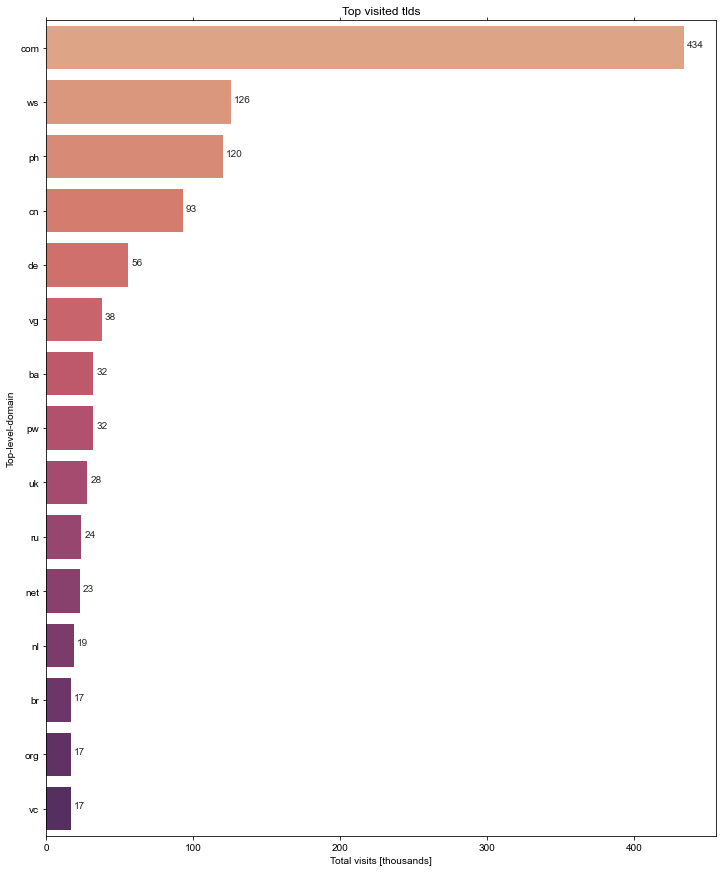

In [15]:
def plot_vertical_box(dataset, x, y, top_results, title):
    plt.figure(figsize=(12, 15))
    ax = sns.barplot(data=dataset[:top_results], x=x, y=y, palette='flare', orient='h')
    plt.ylabel('Top-level-domain')
    plt.xlabel('Total visits [thousands]')
    ax.xaxis.set_ticks_position('both')
    sns.set_style('whitegrid', {'grid.linestyle': '--'})
    show_values(ax, "h", space=2)
    plt.title(title)

plot_vertical_box(top_level_rank, 'visits', 'tld', 15, 'Top visited tlds')

#### There are many country related TLDs on the list. Let's download a dictionary and create a graph only for countries.

In [16]:
# Fetching dictionaries
country_codes = pd.read_csv('country-codes-tlds.csv')
country_codes.columns = ['country', 'tld']
country_codes['tld'] = country_codes['tld'].apply(lambda x: x[2:])
country_codes['country'] = country_codes['country'].apply(lambda x: x.split(',')[0].split('(')[0])
country_codes = country_codes.set_index('tld')
country_codes.head(10)

,country
tld,
af,Afghanistan
ax,Åland
al,Albania
dz,Algeria
as,American Samoa
ad,Andorra
ao,Angola
ai,Anguilla
aq,Antarctica


In [17]:
# Inner join - just to show countries on the plot
countries_rank = top_level_rank.copy()
top_level_rank.columns = ['tld', 'visits']
top_level_rank = top_level_rank.join(country_codes, on=['tld'], how='inner')
top_level_rank[:5]

,tld,visits,country
1,ws,126,Samoa
2,ph,120,Philippines
3,cn,93,China
4,de,56,Germany
5,vg,38,British Virgin Islands


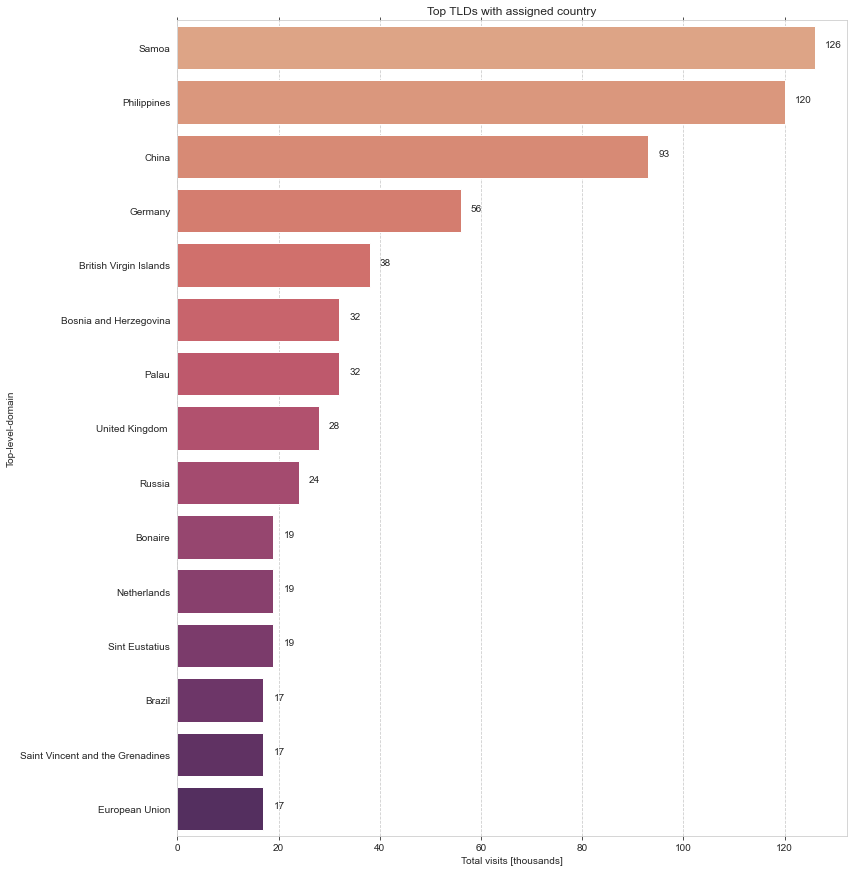

In [18]:
plot_vertical_box(top_level_rank, 'visits', 'country', 15, 'Top TLDs with assigned country')

#### On the ranking we can see many countries close to the Pacific Ocean.

There is a chance that the DNS server is located somewhere close to the Pacific Ocean. So there is chance that most of the users are also there. Because of that note that timezone can be different and the hour might be drifted.

Note: The graph above shows where a web page is registed NOT where a browsing user is.

### Time-based analysis

Now let's focus on how the traffic is structured in a function of time/ hour (we already know it's data from a single day).

In [19]:
group_by_hour = data.groupby('hour').agg(total_requests=('hour', 'count'), most_popular_tld=('top_level_domain', pd.Series.mode))
group_by_hour = group_by_hour.reset_index()
group_by_hour[:5]

,hour,total_requests,most_popular_tld
0,0,39798,com
1,1,35517,com
2,2,27348,com
3,3,36442,com
4,4,40575,com


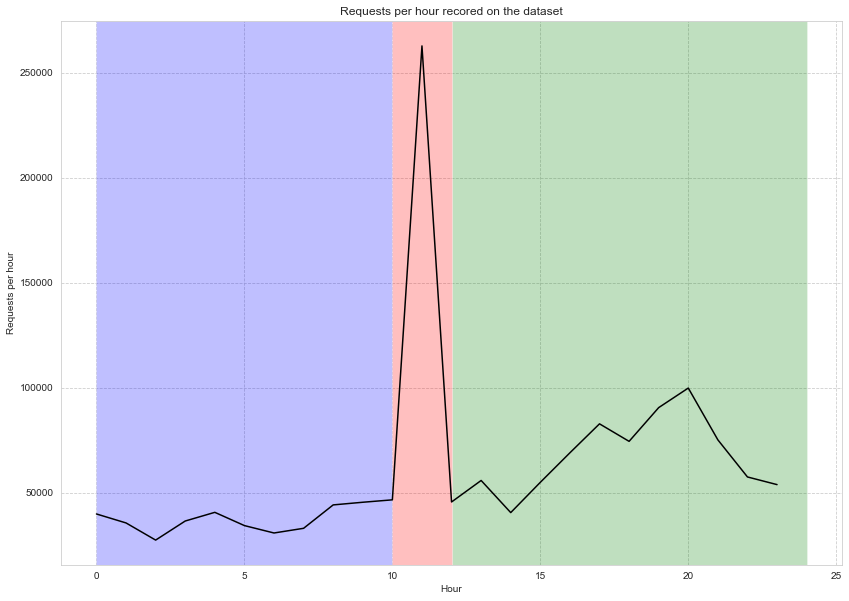

In [20]:
plt.figure(figsize=(14, 10))
ax = sns.lineplot(data=group_by_hour, x='hour', y='total_requests', color='k')
plt.ylabel('Requests per hour')
plt.xlabel('Hour')
plt.title('Requests per hour recored on the dataset')

group_by_hour['background'] = ['blue']*10 + ['red']*2 + ['green']*12
ranges = group_by_hour.groupby('background')['hour'].agg(['min', 'max'])
for i, row in ranges.iterrows():
    ax.axvspan(xmin=row['min'], xmax=row['max']+1, facecolor=i, alpha=0.25)

#### On the graph we can see thee sections:
- An unusual peak: between 10 and 12 hour. This is suspictious. Also, this happened when the usage was relatively low.
- Low trafic area: from data start till arround 14-15 hour.
- High trafic area: from 14-15 almost till the end of data.

Findings from the graph suggest that the timezone of the users isn't UTC.

So now we will investigate the peak and a regular trafic without the peak.

First let's increase the resolution and focus on the peak.

In [21]:
group_by_minutes = data.groupby('hour_minute').agg(total_requests=('hour_minute', 'count'), most_popular_tld=('top_level_domain', pd.Series.mode))
group_by_minutes = group_by_minutes.reset_index()
group_by_minutes[:5]

,hour_minute,total_requests,most_popular_tld
0,00:00,412,ws
1,00:01,821,com
2,00:02,861,com
3,00:03,625,com
4,00:04,389,com


Text(0.5, 1.0, 'Requests per minute during the peak')

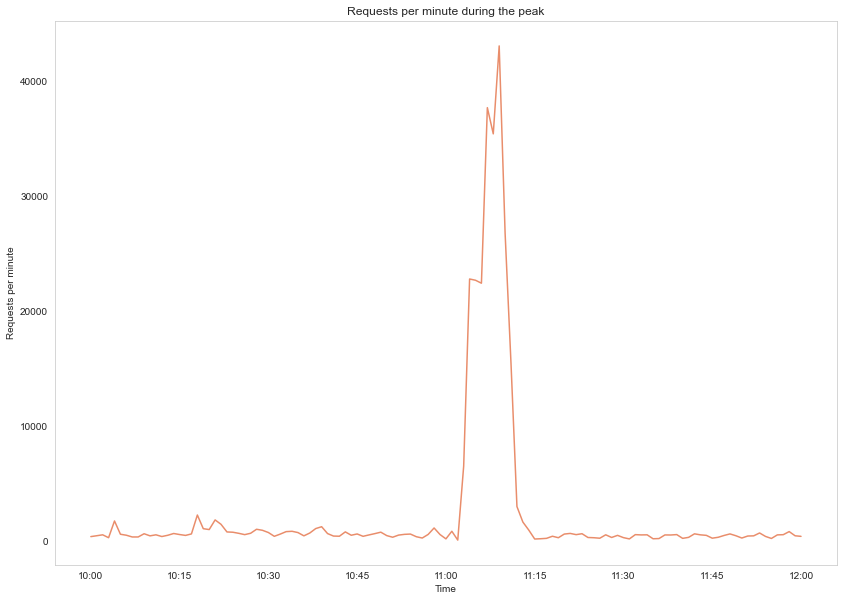

In [22]:
plt.figure(figsize=(14, 10))
ax = sns.lineplot(data=group_by_minutes[10*60: 12*60+1], x='hour_minute', y='total_requests')
n = 15
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.grid(False)
plt.ylabel('Requests per minute')
plt.xlabel('Time')
plt.title('Requests per minute during the peak')

#### Now we can clearly see how steep was the peak, let's find its exact minutes.

Text(0.5, 1.0, 'Requests per minute during the peak')

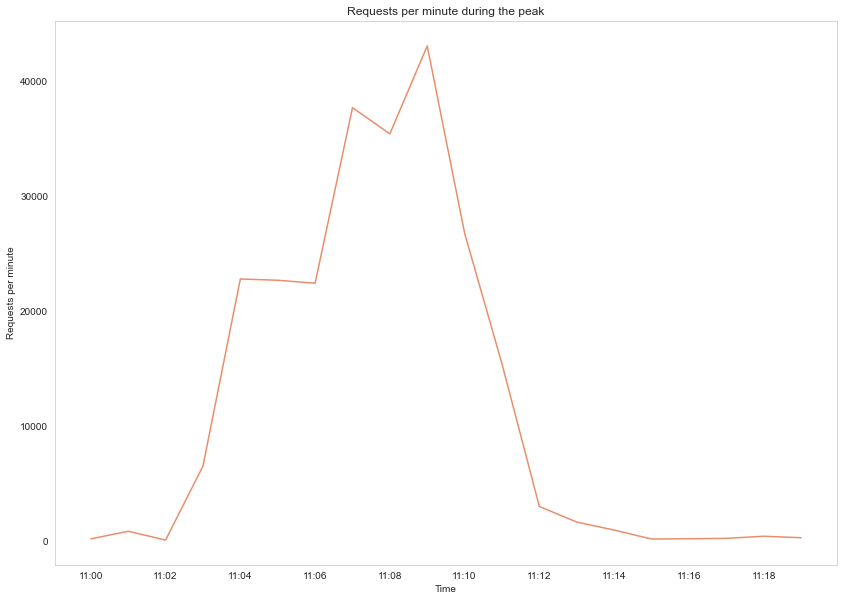

In [23]:
plt.figure(figsize=(14, 10))
ax = sns.lineplot(data=group_by_minutes[11*60: 11*60+20], x='hour_minute', y='total_requests')
n = 2
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.grid(False)
plt.ylabel('Requests per minute')
plt.xlabel('Time')
plt.title('Requests per minute during the peak')

#### The peak was from 11:02 till 11:15.
Let's find the maximum request per second.

In [24]:
max_requests_per_second = data.groupby('timestamp').count()['top_level_domain'].max()
low_traffic_requests_per_second = data[data['hour'].isin(range(0, 8))].groupby('timestamp').count()['top_level_domain'].mean()
high_traffic_requests_per_second = data[data['hour'].isin(range(15, 23))].groupby('timestamp').count()['top_level_domain'].mean()

requests_per_second_summary = pd.DataFrame(columns=['requests per second'])
requests_per_second_summary.at['low trafic (average)', 'requests per second'] = int(low_traffic_requests_per_second)
requests_per_second_summary.at['high trafic (average)', 'requests per second'] = int(high_traffic_requests_per_second)
requests_per_second_summary.at['During the peak (maximum)', 'requests per second'] = max_requests_per_second

requests_per_second_summary

,requests per second
low trafic (average),9
high trafic (average),20
During the peak (maximum),1192


#### So the max number of requests during the peak was 60-130 times higher than average.

Let's pick traffic from the peak and the same length sample before the peak. So we can investigate if there was a change in requested pages structure.

In [25]:
data.head(5)

,timestamp,top_level_domain,second_level_domain,FQDN,resolved IP address,time,hour,minute,hour_minute,first_label
0,1615334400,com,lightningphysics.com,www.lightningphysics.com,34.102.136.180,00:00:00,0,0,00:00,www
1,1615334400,com,petrhaupt.com,_sip._tcp.petrhaupt.com,81.2.195.16,00:00:00,0,0,00:00,_sip
2,1615334400,dk,cservice.dk,cservice.dk,185.21.41.135,00:00:00,0,0,00:00,No first label
3,1615334400,jp,petmode.jp,_sip._tcp.petmode.jp,150.95.255.38,00:00:00,0,0,00:00,_sip
4,1615334400,la,kh6p.int.la,kh6p.int.la,157.119.181.110,00:00:00,0,0,00:00,kh6p


In [26]:
peak_data = data[(data['hour'] == 11) & (data['minute'].isin(range(2, 16)))]
compare_data = data[(data['hour'] == 10) & (data['minute'].isin(range(45, 59)))]

In [27]:
on_off_peak_comparison = pd.DataFrame()
n = 20

for col_name, col in zip(['TLDs', 'SLDs', 'subdomain'], ['top_level_domain', 'second_level_domain', 'first_label']):
    for sample_name, sample in zip(['on peak', 'off peak'], [peak_data, compare_data]):
        ranking = sample.groupby(col).count()['timestamp'].sort_values(ascending=False)[:n]
        on_off_peak_comparison[f'top {col_name} {sample_name}'] = ranking.index
        on_off_peak_comparison[f'{col_name} {sample_name} requests'] = ranking.values
    
on_off_peak_comparison.index += 1    
on_off_peak_comparison

,top TLDs on peak,TLDs on peak requests,top TLDs off peak,TLDs off peak requests,top SLDs on peak,SLDs on peak requests,top SLDs off peak,SLDs off peak requests,top subdomain on peak,subdomain on peak requests,top subdomain off peak,subdomain off peak requests
1,cn,48165,com,1300,-4bqln-rtsqxfdjk.com,1,-5dat5n9ktpwf0nse.com,1,No first label,158824,No first label,5706
2,ws,42477,ws,905,pohadkyonline.cz,1,meine-palette.at,1,www,254,www,185
3,ph,36337,ph,844,poelsma-management.nl,1,megafer.int,1,mail,30,m,6
4,vg,21315,de,614,poeohhajjufsuoirpsdpeissfciobmeb.store,1,megasellers.eu,1,m,16,50-201-21-249-static,5
5,ba,15936,cn,394,poereesbevilale.ml,1,megateleshop.de,1,cpcalendars,13,60-249-200-32,5
6,ga,8147,pw,252,poestaltunbaysenb.tk,1,meicar.cn,1,cpanel,9,mail,5
7,pw,7431,vg,199,poetpills.hu,1,meijieh.com,1,webmail,8,zonemaster,4
8,la,6638,cf,195,poetryfan.de,1,mein-ppc.de,1,autodiscover,7,50-201-210-202-static,4
9,de,5682,watches,185,poff.com.br,1,meineapotheke.eu,1,webdisk,6,49-159-215-182,4
10,nl,4238,vc,182,poffersaanzee.nl,1,merasoft.uz,1,old,6,49-159-214-81,4


#### There aren't any second level domains which appeared in the logs more than one time - it's due to caching. 
A request for cached webpages doesn't get a new log. So analysis for SLDs doesn't make sense. Let's remove them.

In [28]:
on_off_peak_comparison.drop(on_off_peak_comparison.columns[4:8], axis=1, inplace=True)
on_off_peak_comparison

,top TLDs on peak,TLDs on peak requests,top TLDs off peak,TLDs off peak requests,top subdomain on peak,subdomain on peak requests,top subdomain off peak,subdomain off peak requests
1,cn,48165,com,1300,No first label,158824,No first label,5706
2,ws,42477,ws,905,www,254,www,185
3,ph,36337,ph,844,mail,30,m,6
4,vg,21315,de,614,m,16,50-201-21-249-static,5
5,ba,15936,cn,394,cpcalendars,13,60-249-200-32,5
6,ga,8147,pw,252,cpanel,9,mail,5
7,pw,7431,vg,199,webmail,8,zonemaster,4
8,la,6638,cf,195,autodiscover,7,50-201-210-202-static,4
9,de,5682,watches,185,webdisk,6,49-159-215-182,4
10,nl,4238,vc,182,old,6,49-159-214-81,4


#### The main differences between on and off peak:
- .com TLD dissapeared from the top of the list during the peak. Typicaly .com is the top TLD.
    - but generally the TLDs have a proportional increase.
- All the additional requests come for FQDNs without a subdomain. Requests with subdomain didn't get any significant increase during the peak.

### We can assume that this peak was a result of a DDoS attack.

Let's create similar comparison but let's compare low and high traffic time (from humans).

In [29]:
low_traffic_data = data[data['hour'].isin(range(0, 8))]
high_traffic_data = data[data['hour'].isin(range(15, 22))]

low_high_trafic_comparison = pd.DataFrame()
n = 20

for col_name, col in zip(['TLDs', 'subdomain'], ['top_level_domain', 'first_label']):
    for sample_name, sample in zip(['low', 'high'], [low_traffic_data, high_traffic_data]):
        ranking = sample.groupby(col).count()['timestamp'].sort_values(ascending=False)[:n]
        low_high_trafic_comparison[f'top {col_name} on {sample_name} traffic'] = ranking.index
        low_high_trafic_comparison[f'{col_name} requests on {sample_name} traffic'] = ranking.values
    
low_high_trafic_comparison.index += 1    
low_high_trafic_comparison

,top TLDs on low traffic,TLDs requests on low traffic,top TLDs on high traffic,TLDs requests on high traffic,top subdomain on low traffic,subdomain requests on low traffic,top subdomain on high traffic,subdomain requests on high traffic
1,com,85373,com,234982,No first label,117620,No first label,292805
2,ws,28546,ws,24707,_sip,37069,www,96019
3,ph,28545,ph,24640,www,18755,_sip,37661
4,de,8576,cn,21421,mail,531,_sips,35576
5,pw,8445,uk,20568,webmail,449,mail,436
6,cn,7667,de,15772,m,440,webdisk,241
7,vc,5999,ru,13119,webdisk,288,webmail,234
8,net,5819,net,12780,cpcalendars,211,cpanel,208
9,vg,5769,org,10651,cpanel,205,cpcontacts,197
10,watches,5753,ch,9310,cpcontacts,197,cpcalendars,174


### To summarize:
- The data is from a single day. Wednesday 2021-03-10
- The DNS server is located (or used by users from) are of Pacific Ocean
- The logs from the server contain only requests for new FQDNs
- We can see that the traffic is:
    - low between 0 and 14-15 hour with average 9 requests per second 
    - high after 14-15 with 20 requests per second
- From 11:02 till 11:15 there was a DDoS attack
    - during the attack requested addresses were without a subdomain